# Benson Sandbox

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
%matplotlib inline

## Read and prepare data

Read the data into a `pandas` DataFrame.

In [2]:
url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_180106.txt'

In [3]:
df = pd.read_csv(url)

Rename the columns to be more Python-friendly and convert date and time information to the `pandas` datetime format.

In [4]:
df.columns = [c.lower().strip() for c in df.columns]
df.rename(columns={'c/a': 'ca'}, inplace=True)
dt_temp = df.date + ' ' + df.time
df['datetime'] = pd.to_datetime(dt_temp, format='%m/%d/%Y %H:%M:%S')

Drop unnecessary columns.

In [5]:
df.drop(['desc', 'division', 'date', 'time'], axis=1, inplace=True)

Calculate the change in the number of entries from each turnstile reading.  First, group the rows and apply a shift to `entries` and `exits`.  Then subtract the previous reading from the current reading.  Finally, drop null values, unnecessary columns, and drop unreasonably high/low entry and exit volumes.

In [6]:
df['entries_n'] = df.groupby(['station', 'linename', 'ca', 'unit', 'scp']).entries.shift()
df['exits_n'] = df.groupby(['station', 'linename', 'ca', 'unit', 'scp']).exits.shift()

In [7]:
df['entries_d'] = df.entries - df.entries_n
df['exits_d'] = df.exits - df.exits_n

In [8]:
df.drop(['entries', 'entries_n', 'exits', 'exits_n'], axis=1, inplace=True)
df.rename(columns={'entries_d': 'entries', 'exits_d': 'exits'}, inplace=True)
df.dropna(inplace=True)
df = df[(df.entries >= 0) & (df.entries < 2e6)]
df = df[(df.exits >= 0) & (df.exits < 2e6)]
df.reset_index(inplace=True)

## Calculate sums

Aggregate sums of entries and exits for all stations.

In [9]:
sums = df.groupby(['station', 'linename'])[['entries', 'exits']].sum()

These are the top 20 stations by entries.

In [10]:
top_20_entries = sums.sort_values('entries', ascending=False).head(20)
top_20_entries

,,entries,exits
station,linename,,
GRD CNTRL-42 ST,4567S,662877.0,612013.0
34 ST-HERALD SQ,BDFMNQRW,539801.0,504322.0
42 ST-PORT AUTH,ACENQRS1237W,391291.0,304375.0
34 ST-PENN STA,ACE,367573.0,341410.0
47-50 STS ROCK,BDFM,317789.0,307018.0
14 ST-UNION SQ,LNQR456W,298421.0,283198.0
TIMES SQ-42 ST,1237ACENQRSW,289148.0,302167.0
FULTON ST,2345ACJZ,288168.0,251897.0
FLUSHING-MAIN,7,265395.0,220625.0


These are the top 20 stations by exits.

In [11]:
top_20_exits = sums.sort_values('exits', ascending=False).head(20)
top_20_exits

,,entries,exits
station,linename,,
GRD CNTRL-42 ST,4567S,662877.0,612013.0
34 ST-HERALD SQ,BDFMNQRW,539801.0,504322.0
34 ST-PENN STA,ACE,367573.0,341410.0
47-50 STS ROCK,BDFM,317789.0,307018.0
42 ST-PORT AUTH,ACENQRS1237W,391291.0,304375.0
TIMES SQ-42 ST,1237ACENQRSW,289148.0,302167.0
14 ST-UNION SQ,LNQR456W,298421.0,283198.0
FULTON ST,2345ACJZ,288168.0,251897.0
FLUSHING-MAIN,7,265395.0,220625.0


## Search along a particular line

One-hot-encode line names.  There are some mistakes here because ancilary lines like SIR and PATH are also encoded as line 1.  Enter line name as query to filter sums to only stations along the requested line.

In [12]:
one_hot = df.linename.apply(lambda x: list(x)).str.join('|').str.get_dummies()
df = df.join(one_hot)

In [13]:
search_line = 'L'

df[df[search_line] == 1].groupby(['station', 'linename'])\
                            [['entries', 'exits']]\
                            .sum().sort_values('entries', ascending=False)

entries     exits
station         linename                    
14 ST-UNION SQ  LNQR456W  298421.0  283198.0
                456LNQRW  147410.0  135039.0
BEDFORD AV      L         136665.0  148610.0
MYRTLE-WYCKOFF  LM        111532.0   62232.0
8 AV            ACEL      110691.0   72268.0
1 AV            L         108211.0  123442.0
14 ST           ACEL       84257.0   67481.0
                123FLM     79246.0   48300.0
                FLM123     76301.0   93541.0
DEKALB AV       L          55287.0   16167.0
CANARSIE-ROCKAW L          50773.0   15620.0
GRAHAM AV       L          48605.0   36655.0
METROPOLITAN AV GL         42859.0   25891.0
HALSEY ST       L          42392.0   27022.0
BROADWAY JCT    ACJLZ      41153.0   34778.0
MORGAN AV       L          40189.0   19598.0
JEFFERSON ST    L          39781.0   10429.0
MONTROSE AV     L          36761.0   23092.0
3 AV            L          35107.0   35626.0
GRAND ST        L          33792.0   32659.0
LORIMER ST      LG         28635.0    8376.0
WILSON AV       L          22951.0   20841.0
NEW LOTS        L          22396.0   22154.0
EAST 105 ST     L          16673.0   16013.0
6 AV            FLM123     16612.0   13140.0
SUTTER AV       L          15233.0   12913.0
LIVONIA AV      L          14500.0   11206.0
BUSHWICK AV     L          10427.0    7725.0
ATLANTIC AV     L           8100.0    3428.0

## Time-of-day Analysis

### Entries

Pivot the DataFrame to show average entries at each station at each hour's reading.  Resulting DataFrame has many null values where readings were not captured in a particuar hour.

In [14]:
a = df.groupby(['station', 'linename', df.datetime.dt.hour])[['entries', 'exits']].mean().reset_index()
a['station_line'] = a.station + "_" + a.linename
hourly = a.pivot('datetime', 'station_line', 'entries')
hourly.head()

station_line,1 AV_L,103 ST-CORONA_7,103 ST_1,103 ST_6,103 ST_BC,104 ST_A,104 ST_JZ,110 ST_6,111 ST_7,111 ST_A,...,WHITEHALL S-FRY_R1W,WHITLOCK AV_6,WILSON AV_L,WINTHROP ST_25,WOODHAVEN BLVD_JZ,WOODHAVEN BLVD_MR,WOODLAWN_4,WORLD TRADE CTR_ACE23,YORK ST_F,ZEREGA AV_6
datetime,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,159.333333,131.777778,92.055556,NaN,NaN,NaN,NaN,7.976190,...,59.066667,NaN,NaN,69.833333,NaN,111.833333,NaN,NaN,181.388889,16.388889
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,106.45,25.388889,NaN,NaN,NaN,2.5,4.8125,37.222222,24.3,NaN,...,NaN,6.083333,23.0,NaN,10.541667,NaN,28.366667,12.760417,NaN,NaN
4,NaN,NaN,24.833333,26.976190,16.142857,NaN,NaN,NaN,NaN,2.714286,...,14.247619,NaN,NaN,14.071429,NaN,12.272727,NaN,NaN,56.619048,3.285714


In [16]:
targets = list(top_20_entries.reset_index().station + "_" + top_20_entries.reset_index().linename)

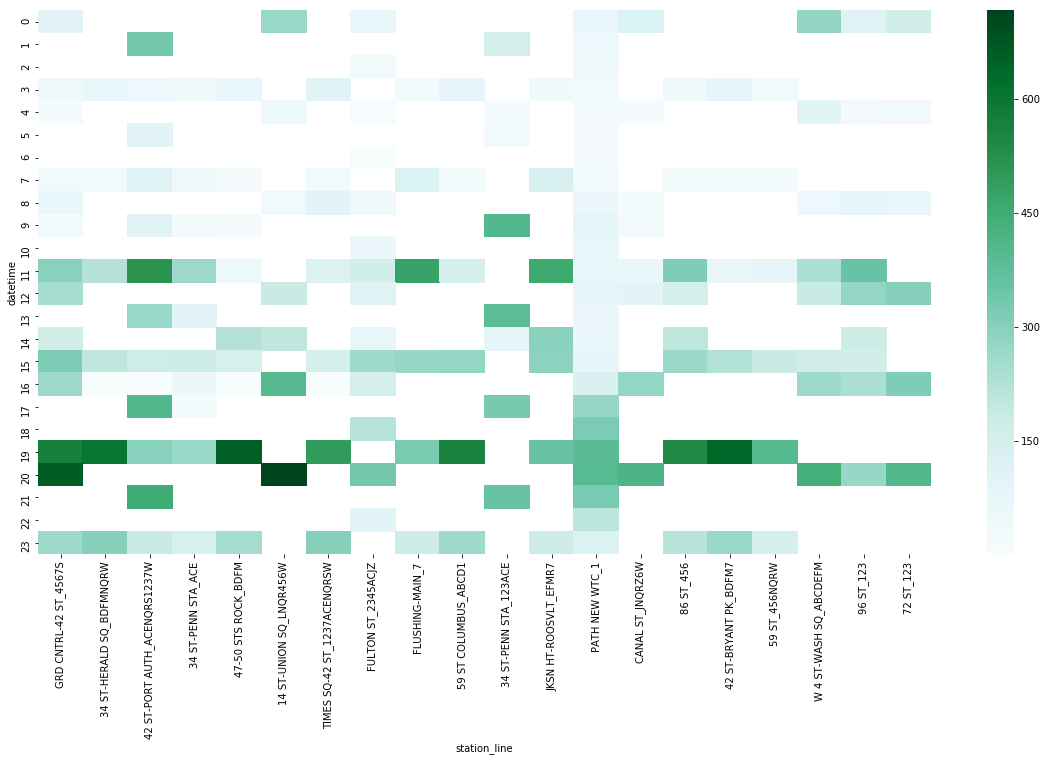

In [17]:
plt.figure(figsize=(20,10))
sns.heatmap(hourly[targets], cmap='BuGn');

### Exits

In [22]:
hourly = a.pivot('datetime', 'station_line', 'exits')
hourly

station_line,1 AV_L,103 ST-CORONA_7,103 ST_1,103 ST_6,103 ST_BC,104 ST_A,104 ST_JZ,110 ST_6,111 ST_7,111 ST_A,...,WHITEHALL S-FRY_R1W,WHITLOCK AV_6,WILSON AV_L,WINTHROP ST_25,WOODHAVEN BLVD_JZ,WOODHAVEN BLVD_MR,WOODLAWN_4,WORLD TRADE CTR_ACE23,YORK ST_F,ZEREGA AV_6
datetime,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,107.638889,190.250000,141.277778,NaN,NaN,NaN,NaN,11.500000,...,66.600000,NaN,NaN,29.208333,NaN,84.121212,NaN,NaN,114.611111,36.638889
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,98.900000,140.666667,NaN,NaN,NaN,7.461538,3.937500,89.333333,129.100000,NaN,...,NaN,17.694444,67.966667,NaN,10.645833,NaN,20.700000,18.718750,NaN,NaN
4,NaN,NaN,24.761905,62.285714,52.523810,NaN,NaN,NaN,NaN,5.183673,...,21.666667,NaN,NaN,7.714286,NaN,26.363636,NaN,NaN,24.142857,15.047619
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,90.328571,40.063492,NaN,NaN,NaN,2.620690,2.470588,48.452381,37.857143,NaN,...,NaN,10.071429,25.028571,NaN,10.250000,NaN,10.514286,23.312500,NaN,NaN
8,NaN,NaN,38.166667,130.952381,42.095238,NaN,NaN,139.333333,NaN,2.265306,...,64.180952,NaN,NaN,28.187500,NaN,32.129870,NaN,NaN,63.095238,32.285714


In [19]:
targets = list(top_20_exits.reset_index().station + "_" + top_20_exits.reset_index().linename)

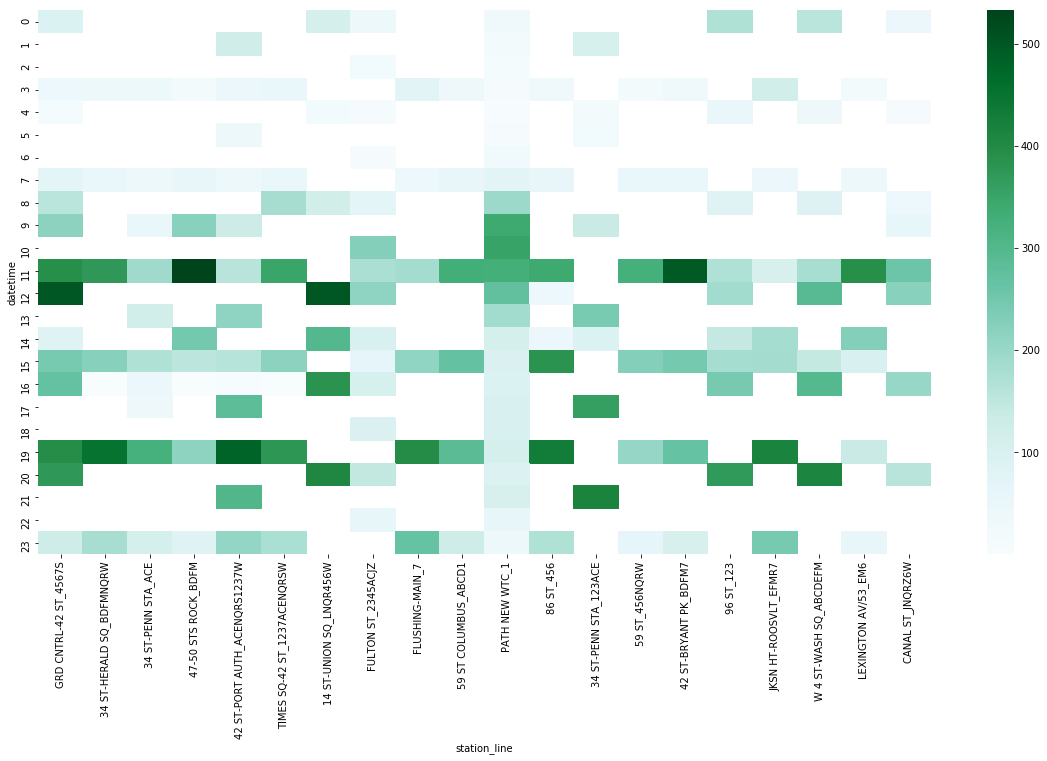

In [20]:
plt.figure(figsize=(20,10))
sns.heatmap(hourly[targets], cmap='BuGn');

To take this forward, should backwards-fill the null values.  Not sure how to do this, need to ask.